In [27]:
import pandas as pd
import numpy as np
from helpers import *
import ast
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")

In [28]:
years = ['twenty2','twenty3','twenty4']
strategies = [
    'CDGAINC_2H',
    'CDGAINP_2H'
              ]
week_dfs = []

for year in years:
    year_data = YEAR_CONFIG[year]
    for file_name in year_data['all_files']:
        for strategy in strategies:
            try:
                week_df = pd.read_csv(f"/Users/charlesmiller/Documents/backtesting_data/TREND55-ALLSEV/{strategy}/{file_name}.csv")
                week_dfs.append(week_df)
            except FileNotFoundError:
                print(f"File {file_name} not found")
                continue

all_data = pd.concat(week_dfs)


File 2024-07-01 not found
File 2024-07-01 not found
File 2024-07-08 not found
File 2024-07-08 not found
File 2024-07-15 not found
File 2024-07-15 not found
File 2024-07-22 not found
File 2024-07-22 not found
File 2024-07-29 not found
File 2024-07-29 not found
File 2024-08-05 not found
File 2024-08-05 not found
File 2024-08-12 not found
File 2024-08-12 not found
File 2024-08-19 not found
File 2024-08-19 not found
File 2024-08-26 not found
File 2024-08-26 not found
File 2024-09-02 not found
File 2024-09-02 not found
File 2024-09-09 not found
File 2024-09-09 not found
File 2024-09-16 not found
File 2024-09-16 not found
File 2024-09-23 not found
File 2024-09-23 not found
File 2024-09-30 not found
File 2024-09-30 not found
File 2024-10-07 not found
File 2024-10-07 not found
File 2024-10-14 not found
File 2024-10-14 not found
File 2024-10-21 not found
File 2024-10-21 not found
File 2024-10-28 not found
File 2024-10-28 not found
File 2024-11-04 not found
File 2024-11-04 not found
File 2024-11

In [29]:
def build_contract_df(row):
    contract = ast.literal_eval(row['contracts'])
    last_price = get_last_price(row)
    row['alert_price'] = last_price
    if len(contract) == 0:
        return pd.DataFrame()
    ## turn a list into a df
    contract_df = pd.DataFrame(contract)
    contract_df.rename(columns={0:'contract_name'}, inplace=True)
    contract_df[['strike','expiry']] = contract_df['contract_name'].apply(lambda x: extract_strike_price(x,row['side']))
    ## find index of the contract with the strike price greater than row['alert_price']
    expiries = ast.literal_eval(row['expiries'])
    contract_dfs = []
    for expiry in expiries:
        expiry_df = contract_df[contract_df['expiry'] == expiry].reset_index(drop=True)
        if row['side'] == 'C':
            select_contracts = expiry_df[expiry_df['strike'] > row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=True, inplace=True)
        elif row['side'] == 'P':
            select_contracts = expiry_df[expiry_df['strike'] < row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=False, inplace=True)
        idx_break = select_contracts.index[0]
        select_contracts = expiry_df.iloc[(idx_break-1):(idx_break+4)]
        # if len(select_contracts) < 5:
        #     print(contract_df)
        #     print(expiry_df)
        #     print(expiry)
        #     print(row['alert_price'])   
        contract_dfs.append(select_contracts)
    for contract_df in contract_dfs:
        # print("LEN CONTRACT DF 3", len(contract_df))
        try:
            contract_df[["max_price","min_price","max_time_diff","min_time_diff","open_price","median_price_appreication"]] = contract_df.apply(lambda x: calculate_contract_price_statistics(x,row), axis=1, result_type='expand')
            contract_df['max_appreciation'] = (contract_df['max_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['max_depreciation'] = (contract_df['min_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['strategy'] = row['strategy']
            contract_df['side'] = row['side']
            contract_df['probability'] = row['probabilities']
            contract_df['label'] = row['label']
            contract_df['date'] = row['dt']
            contract_df['hour'] = row['hour']
            contract_df['minute'] = row['minute']
            contract_df.reset_index(drop=True, inplace=True)
            contract_df['spread_position'] = contract_df.index
        except Exception as e:
            # print(e)
            # print(contract_df)
            # print(row)
            # print()
            continue
    full_contract_df = pd.concat(contract_dfs)
    return full_contract_df

def categorize_week(row):
    if row['symbol'] in ['SPY','QQQ','IWM']:
        if row['day_of_week'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    if row['day_of_week'] == 'Monday':
        if row['days_to_expiry'] == 4:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Tuesday':
        if row['days_to_expiry'] == 3:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Wednesday':
        if row['days_to_expiry'] == 2:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Thursday':
        if row['days_to_expiry'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Friday':
        if row['days_to_expiry'] == 0:
            return 'wk0'
        elif row['days_to_expiry'] == 7:
            return 'wk1'
        else:
            return 'wk2'
    
    

In [30]:
option_price_analytics_dfs =[]
all_data.reset_index(drop=True, inplace=True)
for idx, row in all_data.iterrows():
    try:
        contract_df = build_contract_df(row)
        if contract_df.empty:   
            continue
        option_price_analytics_dfs.append(contract_df)
    except Exception as e:
        print(e)
        print(row['symbol'])
        print(idx)
        print()


index 0 is out of bounds for axis 0 with size 0
META
133

index 0 is out of bounds for axis 0 with size 0
META
280

index 0 is out of bounds for axis 0 with size 0
META
294

index 0 is out of bounds for axis 0 with size 0
META
300

index 0 is out of bounds for axis 0 with size 0
META
306

index 0 is out of bounds for axis 0 with size 0
META
314

index 0 is out of bounds for axis 0 with size 0
META
325

index 0 is out of bounds for axis 0 with size 0
META
340

index 0 is out of bounds for axis 0 with size 0
META
350

index 0 is out of bounds for axis 0 with size 0
META
363

index 0 is out of bounds for axis 0 with size 0
META
385

index 0 is out of bounds for axis 0 with size 0
META
391

index 0 is out of bounds for axis 0 with size 0
META
398

index 0 is out of bounds for axis 0 with size 0
QQQ
410

index 0 is out of bounds for axis 0 with size 0
SPY
411

index 0 is out of bounds for axis 0 with size 0
IWM
412

index 0 is out of bounds for axis 0 with size 0
TSM
415

index 0 is out of 

KeyboardInterrupt: 

In [ ]:
fopa = pd.concat(option_price_analytics_dfs)
fopa.to_csv("option_price_analytics_GAIN.csv", index=False)

In [ ]:
## dropna where date is null
fopa = fopa.dropna(subset=['date'])

In [ ]:
fopa["contract_time"] = fopa["date"].apply(lambda x: pd.to_datetime(x).strftime('%y%m%d'))
fopa['days_to_expiry'] = (pd.to_datetime(fopa["expiry"], format='%y%m%d') - (pd.to_datetime(fopa["contract_time"], format='%y%m%d')))
fopa['days_to_expiry'] = fopa['days_to_expiry'].dt.days
fopa['day_of_week'] = pd.to_datetime(fopa['date']).dt.day_name()
fopa['symbol'] = fopa['contract_name'].apply(lambda x: x[2:-15])
fopa['exp_week'] = fopa.apply(lambda x: categorize_week(x), axis=1)


In [ ]:
fopa.iloc[1]

contract_name                O:TSM220107C00127000
strike                                      127.0
expiry                                     220107
max_price                                     3.3
min_price                                    2.08
max_time_diff                                30.0
min_time_diff                                10.0
open_price                                   1.37
median_price_appreication                   1.555
max_appreciation                              2.3
max_depreciation                             1.08
strategy                               CDGAINC_2H
side                                            C
probability                              0.633438
label                                         1.0
date                                   2022-01-03
hour                                         10.0
minute                                        0.0
spread_position                               1.0
contract_time                              220103


In [ ]:
fopa['max_appreciation'].describe()

count    247821.000000
mean          4.711754
std          10.698966
min          -0.990000
25%           0.430000
50%           1.790000
75%           4.450000
max         155.250000
Name: max_appreciation, dtype: float64

In [ ]:
fopa.loc[fopa['label']== 1]['max_appreciation'].describe()

count    174282.000000
mean          5.057252
std          11.298091
min          -0.990000
25%           0.540000
50%           1.960000
75%           4.750000
max         155.250000
Name: max_appreciation, dtype: float64

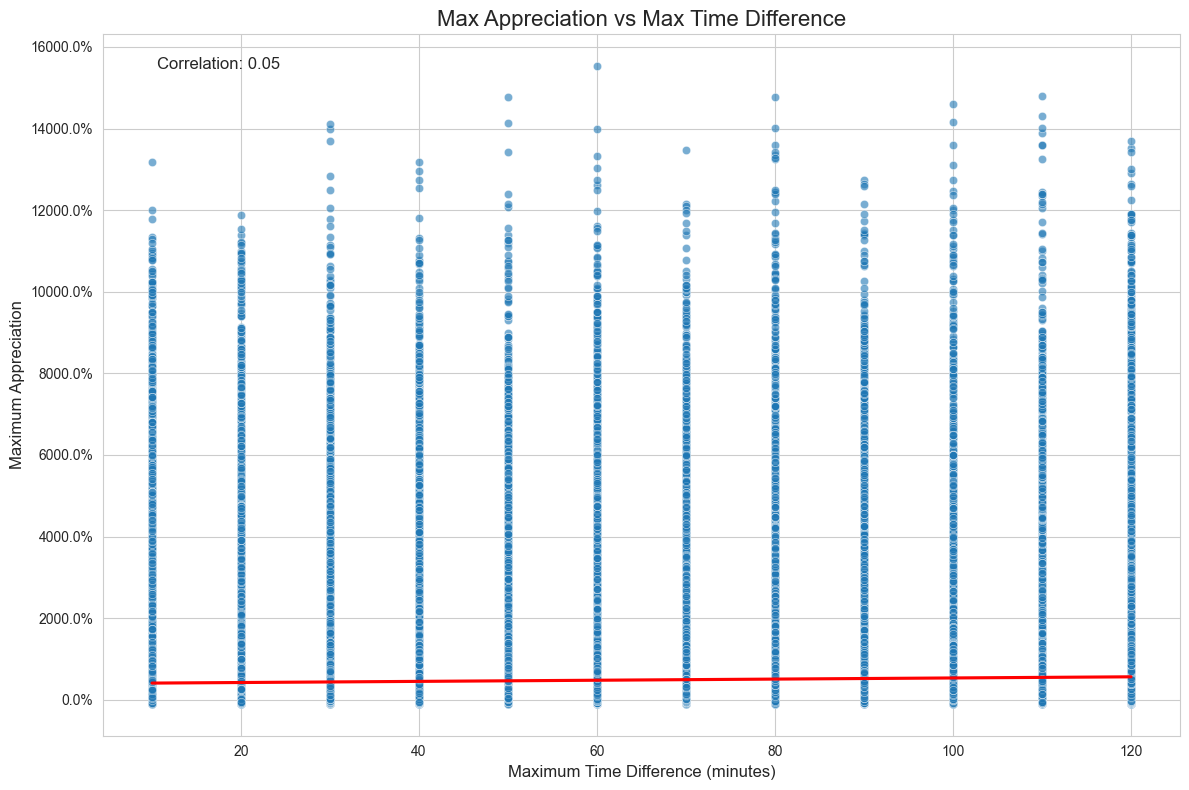

In [ ]:
fopa.reset_index(drop=True, inplace=True)
# Set the style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    alpha=0.6
)

# Add a trend line
sns.regplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    scatter=False,
    color='red'
)

# Customize the plot
plt.title('Max Appreciation vs Max Time Difference', fontsize=16)
plt.xlabel('Maximum Time Difference (minutes)', fontsize=12)
plt.ylabel('Maximum Appreciation', fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add text for correlation
correlation = fopa['max_time_diff'].corr(fopa['max_appreciation'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
result = fopa[(fopa['label'] == 1)].groupby('day_of_week')['max_appreciation'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9])
result

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
day_of_week,,,,,,,,,,,,,,
Friday,30852.0,5.614258,12.384142,-0.99,-0.09,0.49,1.040,1.59,2.20,3.00,4.25,6.44,11.20,136.83
Monday,30763.0,5.316016,11.052164,-0.99,-0.14,0.47,1.010,1.60,2.22,3.05,4.35,6.55,11.05,127.28
Thursday,40143.0,4.335706,10.837901,-0.99,-0.59,-0.08,0.440,0.98,1.56,2.25,3.26,5.14,9.45,155.25
Tuesday,34338.0,5.546511,11.886650,-0.99,-0.23,0.40,0.951,1.51,2.15,2.90,4.10,6.30,11.70,147.82
Wednesday,38186.0,4.717330,10.419391,-0.99,-0.35,0.20,0.720,1.23,1.82,2.55,3.66,5.70,10.07,146.08


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['exp_week'] == 'wk0')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Monday,13412.0,5.003472,10.776782,-0.99,0.43,1.920,5.04,121.45
Thursday,17764.0,3.183366,8.938774,-0.99,-0.40,0.695,2.85,123.74
Tuesday,15373.0,4.859958,10.527765,-0.99,0.26,1.650,4.35,110.75
Wednesday,16847.0,3.830627,8.914447,-0.99,-0.05,1.160,3.66,117.25


In [ ]:
result = fopa[(fopa['label'] == 1) &  (fopa['exp_week'] == 'wk1')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,17336.0,4.659947,11.063797,-0.99,0.45,1.73,4.10,100.60
Monday,17351.0,5.557606,11.254778,-0.99,0.99,2.45,5.45,127.28
Thursday,22379.0,5.250411,12.057665,-0.99,0.80,2.16,4.75,155.25
Tuesday,18965.0,6.103030,12.856807,-0.99,1.04,2.50,5.43,147.82
Wednesday,21339.0,5.417375,11.420552,-0.99,0.93,2.25,5.15,146.08


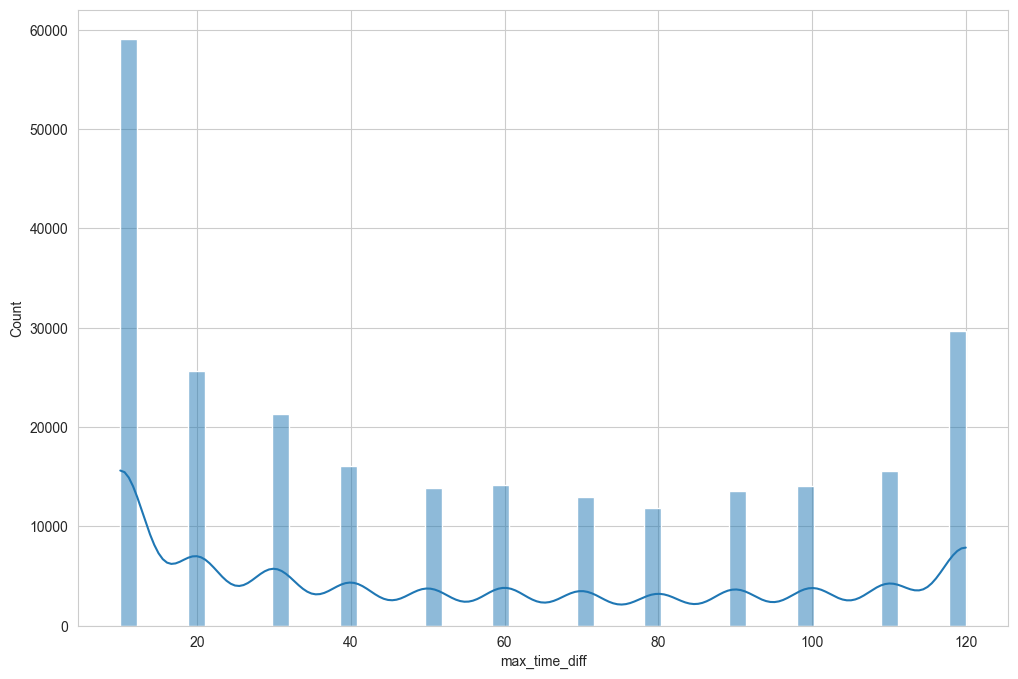

In [ ]:
## create a histogram of the max_time_diff
plt.figure(figsize=(12, 8))
hist = sns.histplot(
    data=fopa,
    x='max_time_diff',
    kde=True
)
# result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_time_diff'].describe()


In [ ]:
result = fopa[fopa['label'] == 1].groupby(['day_of_week','spread_position','exp_week'])['max_appreciation'].describe()
result

count      mean        std   min  \
day_of_week spread_position exp_week                                      
Friday      0.0             wk1       3546.0  4.787321  11.205883 -0.92   
                            wk2       2802.0  7.092141  14.187870 -0.62   
            1.0             wk1       3548.0  4.473334  10.914342 -0.96   
                            wk2       2820.0  6.773135  13.577713 -0.40   
            2.0             wk1       3496.0  4.423152  10.809428 -0.99   
                            wk2       2757.0  6.761513  13.914881 -0.68   
            3.0             wk1       3431.0  4.668522  11.051403 -0.98   
                            wk2       2665.0  6.693689  13.472617 -0.92   
            4.0             wk1       3315.0  4.964275  11.341568 -0.99   
                            wk2       2472.0  6.866371  13.829427 -0.97   
Monday      0.0             wk0       2721.0  4.841588  10.595009 -0.85   
                            wk1       3566.0  5.449641  10.796761 -0.98   
            1.0             wk0       2721.0  4.628659  10.476987 -0.67   
                            wk1       3571.0  5.331199  10.974120 -0.91   
            2.0             wk0       2707.0  4.740894  10.497287 -0.94   
                            wk1       3520.0  5.470423  11.154526 -0.89   
            3.0             wk0       2674.0  5.152696  10.809555 -0.98   
                            wk1       3418.0  5.605641  11.402801 -0.99   
            4.0             wk0       2589.0  5.687957  11.482401 -0.99   
                            wk1       3276.0  5.965485  11.970332 -0.99   
Thursday    0.0             wk0       3620.0  2.862586   8.521438 -0.99   
                            wk1       4585.0  5.132591  11.924947 -0.97   
            1.0             wk0       3621.0  2.609939   8.476048 -0.96   
                            wk1       4590.0  5.019083  11.812912 -0.95   
            2.0             wk0       3609.0  2.847340   8.496064 -0.99   
                            wk1       4522.0  5.056926  11.782995 -0.98   
            3.0             wk0       3546.0  3.510976   9.196271 -0.99   
                            wk1       4439.0  5.374357  12.176661 -0.99   
            4.0             wk0       3368.0  4.159798   9.909338 -0.99   
                            wk1       4243.0  5.704509  12.605993 -0.99   
Tuesday     0.0             wk0       3102.0  4.654826  10.434630 -0.93   
                            wk1       3875.0  6.032854  12.702915 -0.94   
            1.0             wk0       3103.0  4.451905  10.227093 -0.78   
                            wk1       3877.0  5.910487  12.685309 -0.93   
            2.0             wk0       3101.0  4.601383  10.325217 -0.98   
                            wk1       3854.0  5.938921  12.643035 -0.99   
            3.0             wk0       3085.0  5.026441  10.509669 -0.99   
                            wk1       3758.0  6.219763  13.056158 -0.99   
            4.0             wk0       2982.0  5.594618  11.110269 -0.99   
                            wk1       3601.0  6.439664  13.216346 -0.99   
Wednesday   0.0             wk0       3418.0  3.568435   8.632388 -0.98   
                            wk1       4357.0  5.393927  11.456950 -0.94   
            1.0             wk0       3418.0  3.365328   8.546749 -0.91   
                            wk1       4363.0  5.308822  11.575009 -0.95   
            2.0             wk0       3409.0  3.589328   8.900400 -0.98   
                            wk1       4331.0  5.241138  11.204137 -0.99   
            3.0             wk0       3356.0  3.999690   8.899379 -0.99   
                            wk1       4245.0  5.441661  11.407524 -0.99   
            4.0             wk0       3246.0  4.675293   9.537984 -0.99   
                            wk1       4043.0  5.723082  11.456199 -0.99   

                                         25%    50%     75%     max  
day_of_week spread_position exp_week                                

In [ ]:
result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,30852.0,4.307162,10.494614,-0.99,0.26,1.46,3.900,136.83
Monday,30763.0,4.012811,9.163429,-0.99,0.23,1.47,3.935,113.78
Thursday,40143.0,2.777484,8.311682,-0.99,-0.37,0.66,2.500,141.47
Tuesday,34338.0,4.047957,9.462011,-0.99,0.13,1.32,3.550,119.15
Wednesday,38186.0,3.262178,8.304125,-0.99,-0.10,0.97,2.950,146.08


In [ ]:
result = fopa[fopa['label'] == 1].groupby(['day_of_week','symbol','exp_week'])['max_appreciation'].describe()
result.to_csv('symbol_dow_apprc_gain.csv')

In [ ]:
result = fopa[fopa['label'] == 0].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,12700.0,4.502138,10.249477,-0.99,0.50,1.71,4.20,111.50
Monday,13425.0,4.046212,8.854143,-0.99,0.36,1.58,4.00,112.30
Thursday,17323.0,3.168176,8.292135,-0.99,-0.07,1.06,3.10,133.36
Tuesday,14378.0,4.300850,9.682250,-0.99,0.32,1.48,3.80,104.45
Wednesday,15713.0,3.695410,8.399419,-0.99,0.12,1.30,3.51,86.75


In [ ]:
result = fopa[fopa['label'] == 0].groupby([]'day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,12700.0,3.560975,9.135899,-0.99,0.10,1.14,3.20,107.05
Monday,13425.0,3.052203,7.502321,-0.99,-0.04,0.98,3.00,106.78
Thursday,17323.0,2.000275,6.595494,-0.99,-0.53,0.31,1.92,111.17
Tuesday,14378.0,3.190909,8.110177,-0.99,-0.13,0.85,2.76,97.90
Wednesday,15713.0,2.568376,6.786995,-0.99,-0.31,0.63,2.40,72.60
